In [2]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import statistics

In [3]:
market = Market()
speculation_db = ADatabase("cfa")

In [8]:
market.connect()
prices = market.retrieve("prices")
sp5 = market.retrieve("sp500")
market.disconnect()
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [9]:
speculation_db.connect()
simulation = speculation_db.retrieve(f"2022_sim")
speculation_db.disconnect()

In [10]:
simulation.dropna()

,year,quarter,ticker,prediction,training_year,projection_value
0,2018.00,2,MMM,223.369934,1,1
1,2018.00,3,MMM,181.878256,1,1
2,2018.00,3,MMM,193.512960,1,1
3,2018.00,4,MMM,193.721846,1,1
4,2018.25,1,MMM,191.059135,1,1
...,...,...,...,...,...,...
51442,2022.00,2,XYL,118.966917,7,12
51443,2022.00,1,YUM,139.601689,7,12
51444,2022.00,2,YUM,164.695810,7,12
51445,2022.00,1,ZBRA,378.264571,7,12


In [11]:
trades = []
sectors = list(sp5["GICS Sector"].unique())
positions = len(sectors)
start_date = datetime(2020,1,1)
end_date = datetime(2022,7,1)
reqs = [0.1,0.3,0.5]
values = [True]
for projection_value in tqdm([1,4,12]):
    for training_year in [1,4,7]:
        sim = prices.copy().merge(simulation[(simulation["training_year"]==training_year) & \
                                            (simulation["projection_value"]==projection_value)],on=["year","quarter","ticker"],how="left")
        sim = sim.dropna()
        sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
        for value in values:
            iterration_sim = sim.copy()
            if value==True:
                iterration_sim["delta"] = iterration_sim["delta"] * -1
            for req in reqs:
                for position in range(positions):
                    date = start_date
                    sector = sectors[position]
                    while date < end_date:
                        try:
                            year = date.year
                            sector_tickers = list(sp5[sp5["GICS Sector"]==sector]["Symbol"])
                            todays_recs = iterration_sim[(iterration_sim["date"]==date) & (iterration_sim["ticker"].isin(sector_tickers))]
                            todays_recs.sort_values("delta",ascending=False,inplace=True)
                            if (todays_recs.index.size) > 0 and (date.weekday() <= 2):
                                offering = todays_recs.iloc[0]
                                if (offering["delta"] >= req):
                                    trade = offering
                                    ticker = trade["ticker"]
                                    buy_price = trade["adjclose"]
                                    trade_req = req
                                    exits = iterration_sim[(iterration_sim["ticker"]==ticker) & (iterration_sim["date"]>date)]
                                    exits["gains"] = (exits["adjclose"] - buy_price) / buy_price
                                    gain_exits = exits[(exits["gains"]>=trade_req) & (exits["quarter"]==trade["quarter"])
                                                      & (exits["year"]==trade["year"])].sort_values("date")
                                    if gain_exits.index.size < 1:
                                        exit = exits[(exits["quarter"]==trade["quarter"]) & (exits["year"]==trade["year"])].sort_values("date").iloc[-1]
                                        trade["sell_price"] = exit["adjclose"]
                                    else:
                                        exit = gain_exits.iloc[0]
                                        trade["sell_price"] = buy_price * (1+(trade_req))
                                    delta = (trade["sell_price"] - buy_price) / buy_price
                                    trade["projected_delta"] = offering["delta"]
                                    trade["sell_date"] = exit["date"]
                                    trade["position"] = position
                                    trade["req"] = req
                                    trade["value"] = value
                                    trade["training_year"] = training_year
                                    trade["projection_value"] = projection_value
                                    trades.append(trade)
                                    date = exit["date"] + timedelta(days=1)
                                else:
                                    date = date + timedelta(days=1)
                            else:
                                date = date + timedelta(days=1)
                        except Exception as e:
                            print(str(e))
                            date = date+timedelta(days=1)

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

single positional indexer is out-of-bounds


 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 2/3 [37:16<17:44, 1064.10s/it]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [46:52<00:00, 937.64s/it]


In [12]:
int(3/2)

1

In [13]:
t = pd.DataFrame(trades)
t["delta"] = (t["sell_price"] - t["adjclose"]) / t["adjclose"]
t["holding"] = [(row[1]["sell_date"] - row[1]["date"]).days for row in t.iterrows()]

In [15]:
analysis = []
for projection_value in [1,4,12]:
    for training_year in [1,4,7]:
        for value in values:
            for req in reqs:
                for position in range(positions):
                    position_trades = t[(t["position"]==position) & (t["req"]==req) & (t["value"]==value)& (t["training_year"]==training_year) \
                                        & (t["projection_value"]==projection_value)].sort_values("date")
                    initial = 100 / positions
                    for delta in position_trades["delta"]:
                        initial = initial * (1+delta)
                    analysis.append({
                        "value":value,
                        "training_year":training_year,
                        "projection_value":projection_value,
                        "position":position,
                        "req":req,
                        "holding":position_trades["holding"].mean(),
#                         "wr":position_trades[position_trades["delta"]>0].index.size / position_trades.index.size,
                        "pv":initial
                    })
a = pd.DataFrame(analysis)

In [16]:
complete = a.pivot_table(index=["req","value","training_year","projection_value"],columns="position",values="pv").reset_index()
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]
complete.sort_values("pv",ascending=False).head(10)

position,req,value,training_year,projection_value,0,1,2,3,4,5,6,7,8,9,10,pv
19,0.5,True,1,4,16.488943,22.850252,18.085995,6.412533,9.090909,137.969558,9.090909,7.682150,9.878326,9.090909,8.568761,255.209246
10,0.3,True,1,4,17.516468,15.061725,23.045059,9.076700,8.261984,56.541058,9.188152,8.822940,12.750196,9.834261,8.479266,178.577807
22,0.5,True,4,4,11.383522,23.415813,20.679605,9.090909,9.090909,58.700896,9.090909,8.794931,7.396536,9.090909,7.920626,174.655564
25,0.5,True,7,4,15.456297,24.056401,17.217447,9.336499,9.090909,23.414475,9.090909,8.794931,7.663160,9.090909,14.686327,147.898264
6,0.1,True,7,1,7.321659,17.731775,17.313715,17.941389,12.627457,18.083195,8.224855,14.782420,17.057295,9.466231,7.219143,147.769134
16,0.3,True,7,4,14.778890,15.721557,16.326898,9.368476,7.199537,24.812236,9.020284,9.349081,10.330559,10.273711,13.692303,140.873532
14,0.3,True,4,12,17.034038,9.279131,22.740396,12.926740,10.775865,3.657076,14.848626,22.009716,6.158688,7.720579,11.147515,138.298368
13,0.3,True,4,4,17.002493,17.428553,23.162916,7.903458,8.604623,22.219760,8.203895,7.020690,10.474994,9.025721,6.997910,138.045014
3,0.1,True,4,1,9.916307,12.005113,11.625974,13.863469,12.063037,13.841313,9.192000,17.963760,17.774131,11.569049,7.646684,137.460837
0,0.1,True,1,1,11.800971,8.716371,12.294469,16.545998,10.796547,15.867269,10.005625,11.320681,15.972157,13.070075,8.310432,134.700596


In [17]:
complete["training_year"].unique()

array([1, 4, 7], dtype=int64)

In [36]:
best_it = complete.sort_values("pv",ascending=False).iloc[0]
best_trades = t[(t["req"]==best_it["req"])& (t["value"]==best_it["value"]) & (t["training_year"]==best_it["training_year"]) \
               & (t["projection_value"]==best_it["projection_value"])].copy()

In [37]:
best_trades

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,...,training_year,projection_value,delta,sell_price,projected_delta,sell_date,position,req,value,holding
2424601,2020-08-17,182.200,182.5700,177.8000,179.750,813391,182.200000,182.570000,177.800000,179.750000,...,1,4,0.062788,193.640000,0.515530,2020-09-30,0,0.5,True,44
2424635,2020-10-05,207.860,208.2600,198.5300,199.250,805326,207.860000,208.260000,198.530000,199.250000,...,1,4,0.094054,227.410000,0.503720,2020-12-31,0,0.5,True,87
2424707,2021-01-19,267.460,269.5900,255.9400,257.000,756919,267.460000,269.590000,255.940000,257.000000,...,1,4,0.224295,327.450000,0.510778,2021-03-31,0,0.5,True,71
2424759,2021-04-05,325.040,329.2466,322.3000,327.000,480907,325.040000,329.246600,322.300000,327.000000,...,1,4,0.277227,415.150000,0.602392,2021-06-30,0,0.5,True,86
2421713,2021-07-06,12.920,13.3200,12.8200,13.280,70638760,103.092061,106.283766,102.294135,105.964595,...,1,4,-0.002424,102.842117,0.644050,2021-09-30,0,0.5,True,86
2051059,2020-04-20,323.270,328.5300,316.0000,322.870,1294258,80.817500,82.132500,79.000000,80.717500,...,1,4,0.254060,101.350000,0.530169,2020-06-30,1,0.5,True,71
69456,2020-07-01,61.590,63.7300,59.1200,63.000,17916470,61.590000,63.730000,59.120000,63.000000,...,1,4,0.500000,92.385000,0.626472,2020-07-17,1,0.5,True,16
69468,2020-07-20,82.680,90.8500,78.0500,87.860,77855098,82.680000,90.850000,78.050000,87.860000,...,1,4,-0.144291,70.750000,0.721752,2020-09-30,1,0.5,True,72
69522,2020-10-05,71.950,72.0200,69.0500,69.640,6518121,71.950000,72.020000,69.050000,69.640000,...,1,4,0.500000,107.925000,0.628442,2020-11-25,1,0.5,True,51
69561,2020-11-30,152.740,153.8699,141.0500,144.000,73203064,152.740000,153.869900,141.050000,144.000000,...,1,4,-0.316027,104.470000,0.824973,2020-12-31,1,0.5,True,31


In [38]:
all_references = []
for position in tqdm(range(positions)):
    pt = best_trades[best_trades["position"]==position].sort_values("date")
    initial = 10000/positions
    references = []
    for row in tqdm(pt.iterrows()):
        ticker = row[1]["ticker"]
        start_date = row[1]["date"]
        end_date = row[1]["sell_date"]
        amount = initial / prices[(prices["date"]==start_date) & (prices["ticker"]==ticker)].iloc[0]["adjclose"]
        reference = prices[(prices["date"]>=start_date) & (prices["ticker"]==ticker) & (prices["date"]<=end_date)].sort_values("date")
        reference["pv"] = reference["adjclose"] * amount
        reference["position"] = position
        initial = reference["pv"].iloc[-1]
        references.append(reference)
    all_references.extend(references)

  0%|                                                                                                                                     | 0/11 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.72it/s]
2it [00:01,  1.78it/s]
3it [00:01,  1.83it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.82it/s]
  9%|███████████▎                                                                                                                 | 1/11 [00:02<00:27,  2.75s/it]
0it [00:00, ?it/s]
1it [00:00,  1.88it/s]
2it [00:01,  1.81it/s]
3it [00:01,  1.82it/s]
4it [00:02,  1.83it/s]
5it [00:02,  1.82it/s]
6it [00:03,  1.82it/s]
7it [00:03,  1.83it/s]
8it [00:04,  1.85it/s]
9it [00:04,  1.87it/s]
10it [00:05,  1.85it/s]
 18%|██████████████████████▋                                                                                                      | 2/11 [00:08<00:38,  4.31s/it]
0it [00:00, ?it/s]
1it [00:00,  1.86it/s]
2it [00:01,  1.85it/s]
3it [00:01,  1.84it/s]
4it [00:02,  1.85it/s]
5it [00:02,  1.83it

In [39]:
viz = pd.concat(all_references)

In [40]:
viz

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,adjvolume,divcash,splitfactor,ticker,year,week,quarter,pv,position
2410933,2020-08-17,182.20,182.5700,177.8000,179.75,813391,182.20,182.5700,177.8000,179.75,813391,0.0,1.0,GNRC,2020,34,3,909.090909,0
2410934,2020-08-18,181.68,185.5500,180.5000,181.63,771065,181.68,185.5500,180.5000,181.63,771065,0.0,1.0,GNRC,2020,34,3,906.496358,0
2410935,2020-08-19,181.20,183.3675,180.0600,180.15,565107,181.20,183.3675,180.0600,180.15,565107,0.0,1.0,GNRC,2020,34,3,904.101387,0
2410936,2020-08-20,182.45,184.2300,179.4934,180.00,583209,182.45,184.2300,179.4934,180.00,583209,0.0,1.0,GNRC,2020,34,3,910.338290,0
2410937,2020-08-21,186.71,188.5500,182.4700,183.27,720290,186.71,188.5500,182.4700,183.27,720290,0.0,1.0,GNRC,2020,34,3,931.593653,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949850,2022-06-24,26.35,27.0800,25.9000,25.99,23913412,26.35,27.0800,25.9000,25.99,23913412,0.0,1.0,CTRA,2022,25,2,875.482208,10
2949851,2022-06-27,27.03,27.3100,26.1700,26.59,12194085,27.03,27.3100,26.1700,26.59,12194085,0.0,1.0,CTRA,2022,26,2,898.075297,10
2949852,2022-06-28,27.69,27.8290,27.0200,27.43,10274927,27.69,27.8290,27.0200,27.43,10274927,0.0,1.0,CTRA,2022,26,2,920.003883,10
2949853,2022-06-29,26.71,28.3700,26.4600,28.19,7935398,26.71,28.3700,26.4600,28.19,7935398,0.0,1.0,CTRA,2022,26,2,887.443255,10


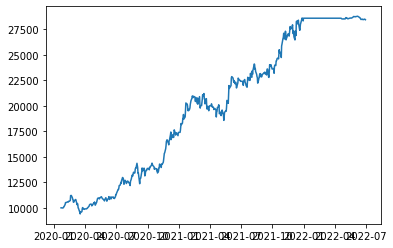

In [41]:
report = viz.pivot_table(index="date",values="pv",columns="position").fillna(method="ffill").fillna(10000/positions)
for i in range(positions):
    if i not in report.columns:
        report[i] = 10000/positions
report["pv"] = [sum([row[1][i] for i in range(positions)]) for row in report.iterrows()]
report.reset_index(inplace=True)
plt.plot(report["date"],report["pv"])
plt.show()

In [42]:
report

position,date,0,1,2,3,5,7,8,10,4,6,9,pv
0,2020-01-22,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,10000.000000
1,2020-01-23,909.090909,909.090909,909.090909,909.090909,913.304688,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,10004.213779
2,2020-01-24,909.090909,909.090909,909.090909,909.090909,901.525260,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,9992.434351
3,2020-01-27,909.090909,909.090909,909.090909,909.090909,890.671587,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,9981.580678
4,2020-01-28,909.090909,909.090909,909.090909,909.090909,904.845207,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,9995.754298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2022-06-24,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,875.482208,909.090909,909.090909,909.090909,28444.088596
529,2022-06-27,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,898.075297,909.090909,909.090909,909.090909,28466.681685
530,2022-06-28,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,920.003883,909.090909,909.090909,909.090909,28488.610271
531,2022-06-29,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,887.443255,909.090909,909.090909,909.090909,28456.049643


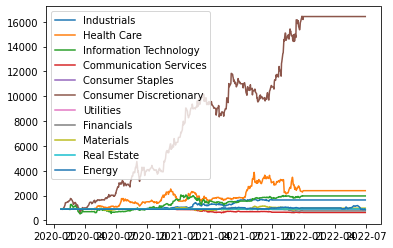

In [56]:
for i in range(0,11):
    plt.plot(report["date"],report[i])
    plt.legend(sectors)
plt.show()

In [44]:
report.corr()

position,0,1,2,3,5,7,8,10,4,6,9,pv
position,,,,,,,,,,,,
0,1.000000,0.841765,0.850115,-0.925891,0.914699,-0.484545,0.558941,0.697164,NaN,NaN,NaN,0.937843
1,0.841765,1.000000,0.794792,-0.716604,0.754270,-0.387374,0.682565,0.489086,NaN,NaN,NaN,0.819173
2,0.850115,0.794792,1.000000,-0.785641,0.903512,-0.463250,0.565292,0.555709,NaN,NaN,NaN,0.928534
3,-0.925891,-0.716604,-0.785641,1.000000,-0.909240,0.449560,-0.379193,-0.686099,NaN,NaN,NaN,-0.907245
5,0.914699,0.754270,0.903512,-0.909240,1.000000,-0.588100,0.411862,0.695680,NaN,NaN,NaN,0.993590
7,-0.484545,-0.387374,-0.463250,0.449560,-0.588100,1.000000,-0.205961,-0.392427,NaN,NaN,NaN,-0.565049
8,0.558941,0.682565,0.565292,-0.379193,0.411862,-0.205961,1.000000,0.317721,NaN,NaN,NaN,0.485805
10,0.697164,0.489086,0.555709,-0.686099,0.695680,-0.392427,0.317721,1.000000,NaN,NaN,NaN,0.689146
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")

In [46]:
bench = p.column_date_processing(bench)
bench

,date,open,high,low,close,adjclose,volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.547983,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.729692,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.784193,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.056755,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.165785,531500
...,...,...,...,...,...,...,...
7372,2022-05-09,405.100006,406.410004,396.500000,398.170013,398.170013,155586100
7373,2022-05-10,404.489990,406.079987,394.820007,399.089996,399.089996,132497200
7374,2022-05-11,398.070007,404.040009,391.959991,392.750000,392.750000,142361000
7375,2022-05-12,389.369995,395.799988,385.149994,392.339996,392.339996,125090800


In [47]:
ds = bench[bench["date"]>=datetime(2020,1,1)].merge(report.rename(columns={"sell_date":"date"}),on="date",how="left").sort_values("date")
ds = ds.fillna(method="ffill").fillna(10000/positions).iloc[2:]

In [48]:
ds

,date,open,high,low,close,adjclose,volume,0,1,2,3,5,7,8,10,4,6,9,pv
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,312.556610,55653900,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909
3,2020-01-07,323.019989,323.540009,322.239990,322.730011,311.677795,40496400,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909
4,2020-01-08,322.940002,325.779999,322.670013,324.450012,313.338867,68296000,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909
5,2020-01-09,326.160004,326.730011,325.519989,326.649994,315.463501,48473300,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909
6,2020-01-10,327.290009,327.459991,325.200012,325.709991,314.555756,53029300,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909,909.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2022-05-09,405.100006,406.410004,396.500000,398.170013,398.170013,155586100,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,954.460931,909.090909,909.090909,909.090909,28523.067319
593,2022-05-10,404.489990,406.079987,394.820007,399.089996,399.089996,132497200,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,964.226903,909.090909,909.090909,909.090909,28532.833291
594,2022-05-11,398.070007,404.040009,391.959991,392.750000,392.750000,142361000,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,962.924773,909.090909,909.090909,909.090909,28531.531161
595,2022-05-12,389.369995,395.799988,385.149994,392.339996,392.339996,125090800,1648.894333,2397.616458,1973.196504,641.253282,16424.325503,768.215018,987.832563,965.854564,909.090909,909.090909,909.090909,28534.460953


In [49]:
ds["bench_prog"] = (ds["adjclose"] - ds["adjclose"].iloc[0]) / ds["adjclose"].iloc[0]
ds["portfolio_prog"] = (ds["pv"] - 10000) / 10000
ds["portfolio_deriv"] = ds["portfolio_prog"].pct_change()
ds["bench_deriv"] = ds["bench_prog"].pct_change()

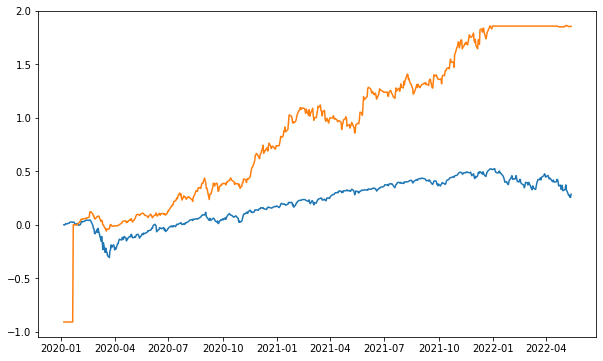

In [50]:
figure, axes = plt.subplots(figsize=(10, 6))
  
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  
axes.plot(ds["date"],
         ds["bench_prog"])
axes.plot(ds["date"],
         ds["portfolio_prog"])

In [51]:
ds.sort_values("portfolio_prog",ascending=False)[["date","bench_prog","portfolio_prog"]].head(20)

,date,bench_prog,portfolio_prog
589,2022-05-04,0.372743,1.863538
591,2022-05-06,0.316050,1.862821
590,2022-05-05,0.323952,1.860608
500,2021-12-27,0.522226,1.860167
588,2022-05-03,0.332175,1.859924
537,2022-02-17,0.394008,1.857548
544,2022-03-01,0.371426,1.857548
515,2022-01-18,0.455980,1.857548
538,2022-02-18,0.384982,1.857548
539,2022-02-22,0.370119,1.857548


In [52]:
best_trades.sort_values("delta",ascending=False).head(20)[["date","holding","projected_delta","delta","ticker","sell_price","adjclose"]]

,date,holding,projected_delta,delta,ticker,sell_price,adjclose
822346,2020-04-06,21,0.527885,0.500000,TSLA,154.872000,103.248000
2378805,2021-01-04,65,1.541543,0.500000,F,12.567519,8.378346
69522,2020-10-05,51,0.628442,0.500000,MRNA,107.925000,71.950000
822406,2020-07-01,47,0.793343,0.500000,TSLA,335.889000,223.926000
69456,2020-07-01,16,0.626472,0.500000,MRNA,92.385000,61.590000
822472,2020-10-05,63,0.857360,0.500000,TSLA,638.520000,425.680000
2201021,2020-10-05,71,0.709877,0.500000,ENPH,147.075000,98.050000
69710,2021-07-06,24,0.596182,0.500000,MRNA,350.010000,233.340000
822294,2020-01-22,13,0.501487,0.500000,TSLA,170.868000,113.912000
2378994,2021-10-04,67,1.610126,0.500000,F,21.167124,14.111416
